In [1]:
!pip install imblearn

In [2]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''
select r.rental_id, f.film_id, f.title, c.category_id, c.name, f.rating, substring(r.rental_date, 1, 10) as rental_date, substring(r.return_date, 1, 10) as return_date, f.rental_duration, f.rental_rate,
case when rental_date between '2005-08-01 00:00:00' and '2005-08-31 23:59:59' then 1 else 0 end as rented_next_month
from sakila.rental r join sakila.inventory using (inventory_id)
join sakila.film f using (film_id) 
join sakila.film_category using (film_id)
join sakila.category c using (category_id)
group by film_id order by film_id asc;
        '''

data = pd.read_sql_query(query, engine)
data

,rental_id,film_id,title,category_id,name,rating,rental_date,return_date,rental_duration,rental_rate,rented_next_month
0,4863,1,ACADEMY DINOSAUR,6,Documentary,PG,2005-07-08,2005-07-11,6,0.99,0
1,10310,2,ACE GOLDFINGER,11,Horror,G,2005-08-01,2005-08-04,3,4.99,1
2,6999,3,ADAPTATION HOLES,6,Documentary,NC-17,2005-07-27,2005-07-29,7,2.99,0
3,6493,4,AFFAIR PREJUDICE,11,Horror,G,2005-07-12,2005-07-16,5,2.99,0
4,552,5,AFRICAN EGG,8,Family,G,2005-05-28,2005-06-04,6,2.99,0
...,...,...,...,...,...,...,...,...,...,...,...
953,4969,996,YOUNG LANGUAGE,6,Documentary,G,2005-07-08,2005-07-12,6,0.99,0
954,7240,997,YOUTH KICK,12,Music,NC-17,2005-07-27,2005-08-03,4,0.99,0
955,1884,998,ZHIVAGO CORE,11,Horror,NC-17,2005-06-17,2005-06-21,6,0.99,0
956,3734,999,ZOOLANDER FICTION,3,Children,R,2005-07-06,2005-07-14,5,2.99,0


# Our target variable will be rented_next_month (0-no or 1-yes), that corresponds with films rented during August 2005

In [4]:
data = data.set_index('rental_id')
data

,film_id,title,category_id,name,rating,rental_date,return_date,rental_duration,rental_rate,rented_next_month
rental_id,,,,,,,,,,
4863,1,ACADEMY DINOSAUR,6,Documentary,PG,2005-07-08,2005-07-11,6,0.99,0
10310,2,ACE GOLDFINGER,11,Horror,G,2005-08-01,2005-08-04,3,4.99,1
6999,3,ADAPTATION HOLES,6,Documentary,NC-17,2005-07-27,2005-07-29,7,2.99,0
6493,4,AFFAIR PREJUDICE,11,Horror,G,2005-07-12,2005-07-16,5,2.99,0
552,5,AFRICAN EGG,8,Family,G,2005-05-28,2005-06-04,6,2.99,0
...,...,...,...,...,...,...,...,...,...,...
4969,996,YOUNG LANGUAGE,6,Documentary,G,2005-07-08,2005-07-12,6,0.99,0
7240,997,YOUTH KICK,12,Music,NC-17,2005-07-27,2005-08-03,4,0.99,0
1884,998,ZHIVAGO CORE,11,Horror,NC-17,2005-06-17,2005-06-21,6,0.99,0


In [5]:
data.dtypes

film_id                int64
title                 object
category_id            int64
name                  object
rating                object
rental_date           object
return_date           object
rental_duration        int64
rental_rate          float64
rented_next_month      int64
dtype: object

In [6]:
data.describe()

,film_id,category_id,rental_duration,rental_rate,rented_next_month
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,8.483299,4.969729,2.977474,0.086639
std,287.541738,4.615321,1.407593,1.643152,0.281452
min,1.000000,1.000000,3.000000,0.990000,0.000000
25%,256.250000,5.000000,4.000000,0.990000,0.000000
50%,504.500000,8.000000,5.000000,2.990000,0.000000
75%,751.750000,13.000000,6.000000,4.990000,0.000000
max,1000.000000,16.000000,7.000000,4.990000,1.000000


In [7]:
data.isna().sum()

film_id              0
title                0
category_id          0
name                 0
rating               0
rental_date          0
return_date          0
rental_duration      0
rental_rate          0
rented_next_month    0
dtype: int64

In [8]:
data['rented_next_month'].value_counts()

0    875
1     83
Name: rented_next_month, dtype: int64

In [9]:
data.corr(method='pearson')

,film_id,category_id,rental_duration,rental_rate,rented_next_month
film_id,1.000000,0.000076,-0.037509,-0.031217,-0.069873
category_id,0.000076,1.000000,0.009814,0.083196,-0.053988
rental_duration,-0.037509,0.009814,1.000000,0.030557,-0.035574
rental_rate,-0.031217,0.083196,0.030557,1.000000,0.015906
rented_next_month,-0.069873,-0.053988,-0.035574,0.015906,1.000000


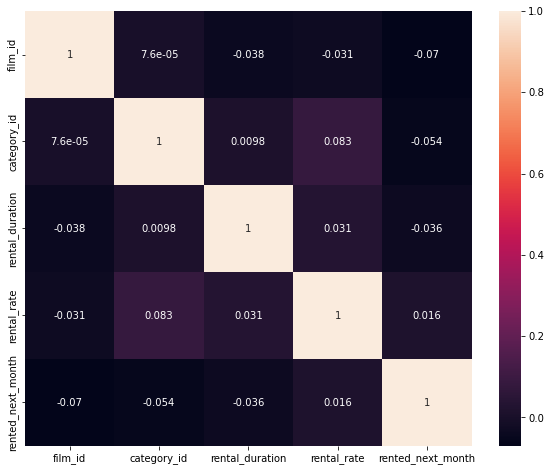

In [10]:
corr_matrix=data.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

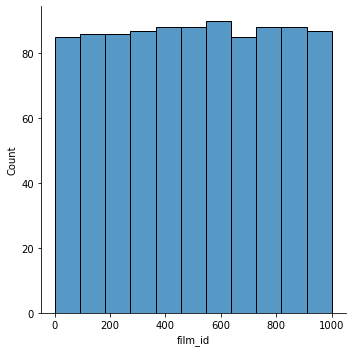

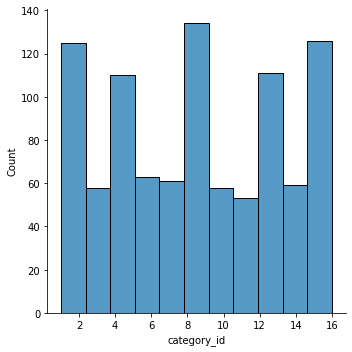

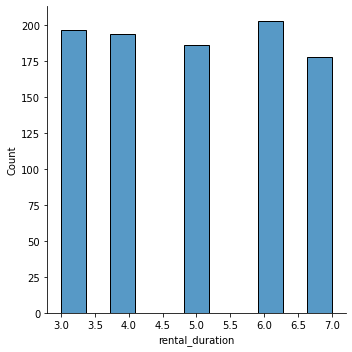

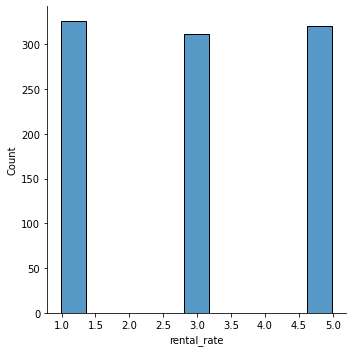

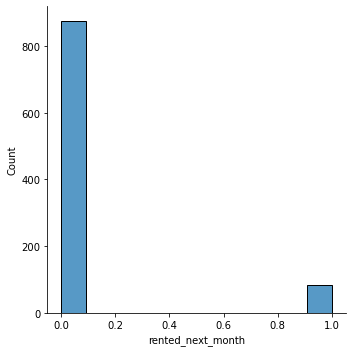

In [11]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

In [15]:
X = pd.get_dummies(data.drop('rented_next_month', axis=1))
y = data['rented_next_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        17

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



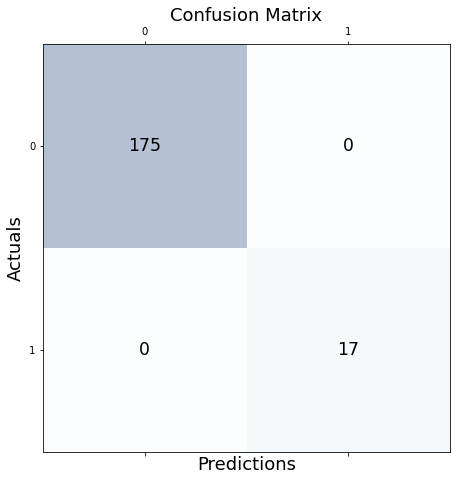

In [32]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

<AxesSubplot:>

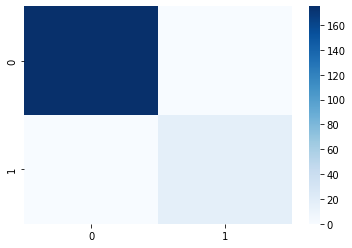

In [20]:
cf_matrix = confusion_matrix(y_test, predictions)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4)
sns.heatmap(cf_matrix, fmt='', cmap='Blues')